In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score)
from sklearn.model_selection import train_test_split
from tqdm import tqdm

#### Read Lunit preds

In [2]:
df_lunit_preds = pd.read_excel('../data/lunit_predictions.xlsx')
print(df_lunit_preds.shape)
df_lunit_preds.head()

(305, 3)


,Patient ID,y_score_0,y_score_1
0,Breast_MRI_549,0.2646,0.7354
1,Breast_MRI_247,0.1412,0.8588
2,Breast_MRI_878,0.3014,0.6986
3,Breast_MRI_875,0.1114,0.8886
4,Breast_MRI_632,0.1778,0.8222


#### Read our preds

In [3]:
df_preds = pd.read_csv('../out/test/preds.csv')
print(df_preds.shape)
df_preds.head()

(305, 4)


,Patient ID,y_score_0,y_score_1,y_true
0,Breast_MRI_002,0.246281,0.753719,0
1,Breast_MRI_004,0.171976,0.828024,1
2,Breast_MRI_006,0.271742,0.728258,1
3,Breast_MRI_007,0.183952,0.816048,1
4,Breast_MRI_010,0.570598,0.429402,0


#### Join data, calculate class labels (threshold=0.5)

In [4]:
df = df_preds.merge(
    right=df_lunit_preds,
    on='Patient ID',
    suffixes=('', '_lunit')
)
df['class'] = (df['y_score_1'] >= 0.5).astype(int)
df['class_lunit'] = (df['y_score_1_lunit'] >= 0.5).astype(int)
df.head()

,Patient ID,y_score_0,y_score_1,y_true,y_score_0_lunit,y_score_1_lunit,class,class_lunit
0,Breast_MRI_002,0.246281,0.753719,0,0.2038,0.7962,1,1
1,Breast_MRI_004,0.171976,0.828024,1,0.1782,0.8218,1,1
2,Breast_MRI_006,0.271742,0.728258,1,0.2056,0.7944,1,1
3,Breast_MRI_007,0.183952,0.816048,1,0.1586,0.8414,1,1
4,Breast_MRI_010,0.570598,0.429402,0,0.5102,0.4898,0,0


#### Statistics

In [5]:
df.describe()

,y_score_0,y_score_1,y_true,y_score_0_lunit,y_score_1_lunit,class,class_lunit
count,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000
mean,0.241661,0.758339,0.744262,0.234121,0.765879,0.967213,0.977049
std,0.110915,0.110915,0.436992,0.100203,0.100203,0.178371,0.149993
min,0.074564,0.285029,0.000000,0.051400,0.303600,0.000000,0.000000
25%,0.163963,0.703949,0.000000,0.164200,0.710600,1.000000,1.000000
50%,0.215199,0.784801,1.000000,0.220000,0.780000,1.000000,1.000000
75%,0.296051,0.836037,1.000000,0.289400,0.835800,1.000000,1.000000
max,0.714971,0.925436,1.000000,0.696400,0.948600,1.000000,1.000000


#### ROC-AUC for our preds

In [6]:
roc_auc_score(y_true=df['y_true'], y_score=df['y_score_1'])

0.6364226815768667

#### ROC-AUC for Lunit preds

In [7]:
roc_auc_score(y_true=df['y_true'], y_score=df['y_score_1_lunit'])

0.617671975601491

#### Confusion matrices for our and Lunit preds

In [8]:
print(confusion_matrix(
    y_true=df['y_true'],
    y_pred=df['class']
))
print(confusion_matrix(
    y_true=df['y_true'],
    y_pred=df['class_lunit']
))

[[  7  71]
 [  3 224]]
[[  6  72]
 [  1 226]]


#### Classification report for our and Lunit preds

In [9]:
print(classification_report(
    y_true=df['y_true'],
    y_pred=df['class']
))
print(classification_report(
    y_true=df['y_true'],
    y_pred=df['class_lunit']
))

              precision    recall  f1-score   support

           0       0.70      0.09      0.16        78
           1       0.76      0.99      0.86       227

    accuracy                           0.76       305
   macro avg       0.73      0.54      0.51       305
weighted avg       0.74      0.76      0.68       305

              precision    recall  f1-score   support

           0       0.86      0.08      0.14        78
           1       0.76      1.00      0.86       227

    accuracy                           0.76       305
   macro avg       0.81      0.54      0.50       305
weighted avg       0.78      0.76      0.68       305



#### Scores distribution for class 1 (our vs Lunit)

<Axes: ylabel='Density'>

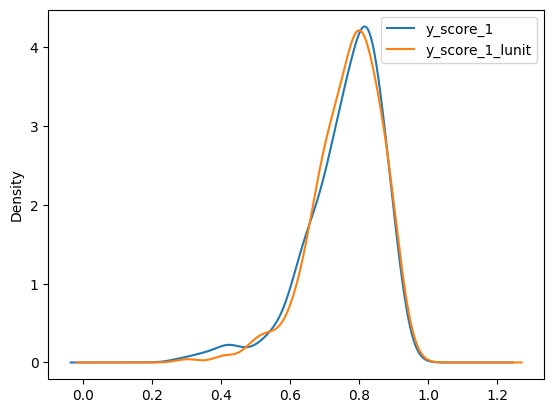

In [10]:
df['y_score_1'].plot(kind='kde', legend=True)
df['y_score_1_lunit'].plot(kind='kde', legend=True)

#### Our model scores for class 1 conditioned on true label

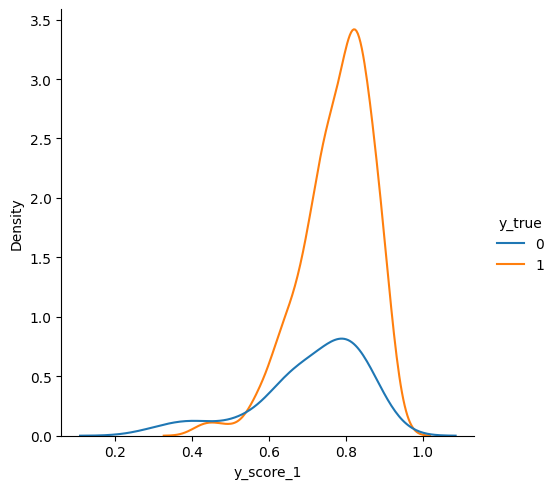

In [11]:
sns.displot(data=df, x='y_score_1', hue='y_true', kind='kde')

#### Lunit model scores for class 1 conditioned on true label

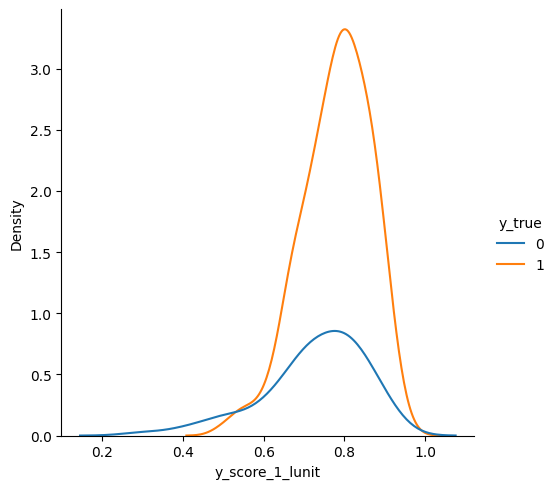

In [12]:
sns.displot(data=df, x='y_score_1_lunit', hue='y_true', kind='kde')

#### After all, our model predicts ER status slightly better (according to ROC-AUC): ~0.64 vs ~0.62

#### Read clinical and other features

In [13]:
df_clinical_features = pd.read_excel(
    '../data/Clinical_and_Other_Features.xlsx',
    header=[1],
    skiprows=[2]
)
print(df_clinical_features.shape)
df_clinical_features.head()

(922, 98)


,Patient ID,Days to MRI (From the Date of Diagnosis),Manufacturer,Manufacturer Model Name,Scan Options,Field Strength (Tesla),Patient Position During MRI,Image Position of Patient,Contrast Agent,Contrast Bolus Volume (mL),...,Therapeutic or Prophylactic Oophorectomy as part of Endocrine Therapy,Neoadjuvant Anti-Her2 Neu Therapy,Adjuvant Anti-Her2 Neu Therapy,Received Neoadjuvant Therapy or Not,Pathologic response to Neoadjuvant therapy: Pathologic stage (T) following neoadjuvant therapy,Pathologic response to Neoadjuvant therapy: Pathologic stage (N) following neoadjuvant therapy,Pathologic response to Neoadjuvant therapy: Pathologic stage (M) following neoadjuvant therapy,Overall Near-complete Response: Stricter Definition,Overall Near-complete Response: Looser Definition,Near-complete Response (Graded Measure)
0,Breast_MRI_001,6,2,0,5,1,0,-191.8003 X -176.1259 X 86.6065,1.0,15.0,...,1,1.0,1.0,1.0,1.0,-1.0,-1.0,0.0,0.0,0.0
1,Breast_MRI_002,12,0,4,1,3,0,154.724 X 176.048 X 94.5771,1.0,NaN,...,0,0.0,0.0,1.0,NaN,NaN,NaN,2.0,2.0,4.0
2,Breast_MRI_003,10,0,3,2,3,0,174.658 X 228.317 X 88.4878,1.0,NaN,...,0,0.0,0.0,1.0,1.0,1.0,-1.0,0.0,0.0,0.0
3,Breast_MRI_004,18,0,4,1,1,0,188.148 X 194.282 X 94.1832,1.0,NaN,...,0,0.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
4,Breast_MRI_005,12,2,0,5,1,1,-173.063 X -150.7869 X 59.161,1.0,5.0,...,0,1.0,1.0,1.0,0.0,0.0,-1.0,1.0,1.0,1.0


#### Join a Manufacturer

In [14]:
df = df.merge(
    right=df_clinical_features[['Patient ID', 'Manufacturer']],
    on='Patient ID'
)
print(df.shape)
df.head()

(305, 9)


,Patient ID,y_score_0,y_score_1,y_true,y_score_0_lunit,y_score_1_lunit,class,class_lunit,Manufacturer
0,Breast_MRI_002,0.246281,0.753719,0,0.2038,0.7962,1,1,0
1,Breast_MRI_004,0.171976,0.828024,1,0.1782,0.8218,1,1,0
2,Breast_MRI_006,0.271742,0.728258,1,0.2056,0.7944,1,1,0
3,Breast_MRI_007,0.183952,0.816048,1,0.1586,0.8414,1,1,2
4,Breast_MRI_010,0.570598,0.429402,0,0.5102,0.4898,0,0,0


#### Number of patients per manufacturer

In [15]:
df['Manufacturer'].value_counts()

Manufacturer
0    213
2     92
Name: count, dtype: int64

#### ROC-AUC score for patients that have MRI from Siemens

In [16]:
roc_auc_score(
    y_true=df[df['Manufacturer'] == 2]['y_true'],
    y_score=df[df['Manufacturer'] == 2]['y_score_1']
)

0.6943919344675488

#### Let's make several rounds of stratified sampling from GE subset and compute a confidence interval for ROC-AUC

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:00<00:00, 60.74it/s]


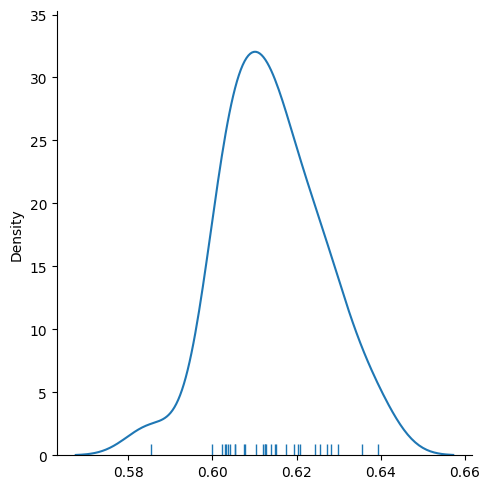

In [17]:
sample_size = 30
bootstrap_rounds = 30 
n_siemens = df['Manufacturer'].value_counts()[2]

df_GE = df[df['Manufacturer'] == 0]
sample_means = []
for _ in tqdm(range(bootstrap_rounds)):
    roc_auc_hist = []
    for _ in range(sample_size):
        _, df_curr, _, _  = train_test_split(df_GE, df_GE['y_true'], test_size=n_siemens)
        roc_auc_hist.append(roc_auc_score(
            y_true=df_curr['y_true'],
            y_score=df_curr['y_score_1']
        ))
    sample_means.append(np.mean(roc_auc_hist))
sns.displot(sample_means, kind='kde', rug=True)

#### Median/mean for sample of means

In [18]:
np.median(sample_means), np.mean(sample_means)

(0.6126886700257188, 0.6140366026165651)

#### 95% confidence interval

In [19]:
confidence = 0.95

stats.t.interval(
    confidence=confidence, 
    df=len(sample_means) - 1, 
    loc=np.mean(sample_means),
    scale=stats.sem(sample_means)
)

(0.6096649594163753, 0.6184082458167549)

#### As far:
- According to ROC-AUC (0.636 vs 0.617), our model performs slightly better (at least on test set)
- 95% confidence interval for GE ROC-AUC on test set is [0.613, 0.622]
- Test ROC-AUC for Siemens is 0.694
- Taking into account the number of samples available for Siemens/GE during train/test (202/415 and 92/213), it's not likely that performance difference between manufacturers were caused by chance. However, predictions were made by model that already seen both manufacturers during training stage, which brings some caveats and uncertainty to conclusions. Anyway, if it was me, I would probably recommend to switch from GE to Siemens.

More fair experiment (in my opinion):
- Take two samples of patients (one for train, one for test)
- Collect features for both samples using GE and Siemens equipment
- Now we have 2 train sets and 2 test sets (one for GE, one for Siemens), but with same targets
- Fit 2 different models on train sets and make predictions on corresponding test sets
- Compare results